# Temperature, Plane Body (Fourier method)

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.integrate import quad, dblquad, tplquad
import numpy as np
import pandas as pd

from IPython.display import clear_output
import joblib

### 0. Appendix: integrals numerical calculation

#### 0.1. Single integrals calculation

In [48]:
# def f1(x,m,n):
#     return x*x + n*x + m

a, b = 5, 5
f1 = lambda x,m,n: x*x + n*x + m # equivalent expression using lambda

m, n = 2, 2
integrad = quad(f1, 0, a, args=(m,n))
print(f"One-dimentional integrad = {integrad[0]}, precision = {integrad[1]}")

One-dimentional integrad = 76.66666666666667, precision = 8.511709855459534e-13


#### 0.2. Double (surface) integrals calculation

In [49]:
# def f2(x,y,m,n):
#     return x*y + n*x + m*y

f2 = lambda x,y,m,n: x*y + n*x + m*y # equivalent expression using lambda

m, n = 2, 2
surface_integrad = dblquad(f2, 0, a, 0, b, args=(m,n))
print(f"Two-dimentional surface integrad = {surface_integrad[0]}, precision = {surface_integrad[1]}")

Two-dimentional surface integrad = 406.25, precision = 4.5102810375396984e-12


#### 0.3. Triple (volume) integrals calculation

In [50]:
# def f3(x,y,z,m,n):
#     return x*y*z + n*x*z + m*y

f3 = lambda x,y,z,m,n: x*y*z + n*x*z + m*y # equivalent expression using lambda

m, n = 2, 2
volume_integrad = tplquad(f3, 0, a, 0, b, 1, 3, args=(m,n))
print(f"Three-dimentional volume integrad = {volume_integrad[0]}, precision = {volume_integrad[1]}")

Three-dimentional volume integrad = 1375.0, precision = 1.5265566588595902e-11


### 1. Initialization

#### 1.1. Physics parameters

In [8]:
# Whole plane body size 0 < x < a and 0 < y < b
a = 5
b = 5

# Grid will be (Nx-1) * (Ny-1) elements
Nx = 50
Ny = 50

x_grid = np.outer(np.linspace(0, a, Nx), np.ones(Nx))
y_grid = np.outer(np.linspace(0, b, Ny), np.ones(Ny)).T

# Physical parameters
kx, ky, c, rho = 1, 1, 1, 1

#### 1.2. Initial temperature

In [4]:
# Parameters of "bell" temperatute distribution T(x,y) at the initial moment t=0
mu_x = 2.5
mu_y = 2.5
sigma_x = np.sqrt(1)
sigma_y = np.sqrt(1)

# Parameters of "plato" temperatute distribution T(x,y) at the initial moment t=0
plato_initial_level = 30.0

# Set initial temperatute distribution
U0_type = "Gauss" # "cosine", "Gauss", "plato"

if U0_type == "cosine": # edge conditions: Q = 0 
    U0_args = []
    plt_zlim_bottom, plt_zlim_top = -1.1, 1.1
if U0_type == "Gauss":  # edge conditions: Q = 0
    U0_args = [mu_x, mu_y, sigma_x, sigma_y]
    plt_zlim_bottom, plt_zlim_top = 0.0, 1.1
if U0_type == "plato":  # edge conditions: T = 0
    U0_args = [plato_initial_level]
    plt_zlim_bottom, plt_zlim_top = 0.0, plato_initial_level

#### 1.3. Fourier's method parameters

In [5]:
# Set number of Fourier members 
N, M = 30, 30

# Set points to observe values in
if U0_type == "Gauss" and a == 5 and b == 5:
    points_of_observations = np.array([
        [2.5,2.5],
        [3.5,2.5],
        [4.5,2.5],
        [3.5,3.5],
        [4.5,4.5],
    ])
elif U0_type == "plato" and a == 3 and b == 3:
    points_of_observations = np.array([
        [1.5,1.5],
        [2.1,1.5],
        [2.5,1.5],
        [2.1,2.1],
        [2.5,2.5],
    ])
else:
    points_of_observations = np.array([
        [a/2,b/2]
    ])

dt = 0.2
Trange = np.round(np.arange(start=0, stop=1.2+dt, step=dt),15)

# Trange = np.array([0.0, 0.24, 0.48, 0.72, 0.96, 1.2])
# Trange = np.array([0.0, 0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0])

print(f"Time delta: dt = {Trange[1]-Trange[0]}, Trange = {Trange}")

Time delta: dt = 0.2, Trange = [0.  0.2 0.4 0.6 0.8 1.  1.2]


### 2. Display initial temperature distribution

In [6]:
def U0(x,y,*args):
    if U0_type == "cosine":
        return np.cos(2*np.pi*x/a)
    if U0_type == "Gauss":
        mu_x, mu_y, sigma_x, sigma_y = args[0], args[1], args[2], args[3]
        return np.exp(-(((x-mu_x)/sigma_x)**2 + ((y-mu_y)/sigma_y)**2)/2)
    if U0_type == "plato":
        initial_level = args[0]
        # return a single value or an array
        return initial_level*np.ones((len(x),len(y))) if type(x) != np.float64 else initial_level

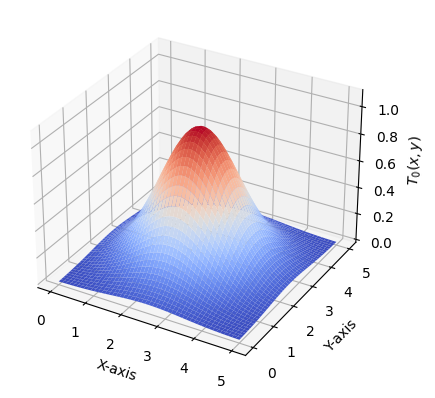

In [9]:
ax0 = plt.axes(projection ="3d")

ax0.plot_surface(
    X = x_grid, 
    Y = y_grid,
    Z = U0(x_grid,y_grid,*U0_args),
    cmap=cm.coolwarm
)
ax0.set_ylabel("Y-axis")
ax0.set_xlabel("X-axis")
ax0.set_zlabel(r"$T_0(x,y)$")
ax0.set_zlim(plt_zlim_bottom,plt_zlim_top)
plt.title("Initial temperature at t = 0.0")
plt.savefig(f"Images/Fourier: {U0_type} initial temperature.png", dpi=500, bbox_inches="tight")
plt.show()

### 3. Perform Fourier method

In [56]:
def U_surface_integrad(x,y,n,m,a,b):
    return U0(x,y,*U0_args)*np.cos((np.pi*n*x)/a)*np.cos((np.pi*m*y)/b)

In [57]:
def C_coeffs(n,m):
    if U0_type in ["cosine","Gauss"]:
        if n == 0 and m == 0:
            norma = a*b
        if (n == 0 and m > 0) or (n > 0 and m == 0):
            norma = a*b/2
        if m > 0 and n > 0:
            norma = a*b/4
        
        numerator, error = dblquad(
            U_surface_integrad, 0, b, 0, a, args=(n,m,a,b)
        )
        Cnm = numerator / norma
        
        return Cnm, error
    if U0_type == "plato":
        Cnm = 4*plato_initial_level*np.abs((-1)**n - 1)*np.abs((-1)**m - 1)/(n*m*np.pi**2)
        return Cnm

In [58]:
def run_Fourier_method(N,M,C,Trange):
    x = np.linspace(0, a, Nx)
    y = np.linspace(0, b, Ny)
    U = np.zeros((len(Trange),len(x),len(y)))

    print(f"Progress bar: 0%")
    for t in range(len(Trange)):
        for i in range(len(x)):
            for j in range(len(y)):
                if U0_type in ["cosine","Gauss"]:
                    for n in range(0,N,2):
                        for m in range(0,M,2):
                            U[t][i][j] += C[n][m]*np.cos(np.pi*n*x[i]/a)*np.cos(np.pi*m*y[j]/b)*np.exp(
                                (-np.pi**2*(kx*n**2/a**2 + ky*m**2/b**2))*Trange[t]
                            )
                if U0_type == "plato":
                    for n in range(N):
                        for m in range(M):
                            U[t][i][j] += C[n][m]*np.sin(np.pi*n*x[i]/a)*np.sin(np.pi*m*y[j]/b)*np.exp(
                                (-np.pi**2*(kx*n**2/a**2 + ky*m**2/b**2))*Trange[t]
                            )
        clear_output()
        print(f"Progress bar: {100*((t+1)/len(Trange))}%")
    return U

In [59]:
def run_point_Fourier_method(x,y,t,N,M,C):
    U_point_result = 0

    if U0_type in ["cosine","Gauss"]:
        for n in range(0,N,2):
            for m in range(0,M,2):
                U_point_result += C[n][m]*np.cos(np.pi*n*x/a)*np.cos(np.pi*m*y/b)*np.exp(
                    (-np.pi**2*(n**2/a**2 + m**2/b**2))*t
                )
    if U0_type == "plato":
        for n in range(1,N):
            for m in range(1,M):
                U_point_result += C[n][m]*np.sin(np.pi*n*x/a)*np.sin(np.pi*m*y/b)*np.exp(
                    (-np.pi**2*(kx*n**2/a**2 + ky*m**2/b**2))*t
                )
    
    return U_point_result

#### 3.1. Calculate Fourier members

In [60]:
integrad_error = 0

C = np.zeros((N,M))
if U0_type in ["cosine","Gauss"]:
    for n in range(0,N,2):
        for m in range(0,M,2):
            C[n][m], error = C_coeffs(n,m)
            integrad_error += error
if U0_type == "plato":
    for n in range(1,N):
        for m in range(1,M):
            C[n][m] = C_coeffs(n,m)

#### 3.2. Run the main algorithm

In [61]:
U = run_Fourier_method(N,M,C,Trange)

Progress bar: 100.0%


### 4. Display the results

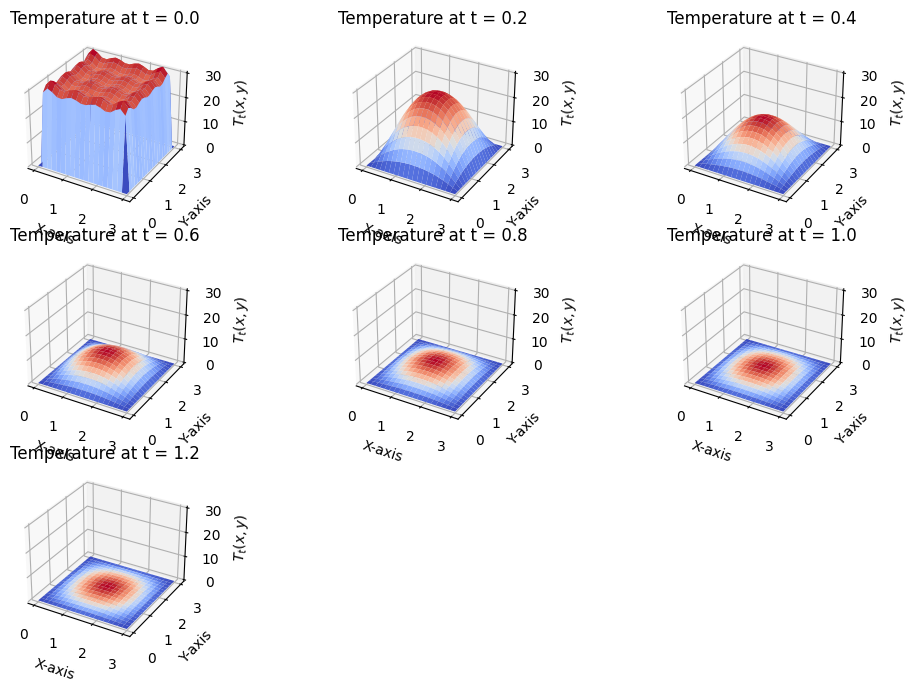

In [62]:
Ut_anchor_points = np.zeros((len(Trange),len(points_of_observations)))

fig = plt.figure(figsize=(12,8))
for t in range(len(Trange)):
    ax = fig.add_subplot((len(Trange)-1)//3 + 1, 3, t+1, projection="3d")
    ax.plot_surface(x_grid, y_grid, U[t], cmap=cm.coolwarm)
    ax.set_ylabel("Y-axis")
    ax.set_xlabel("X-axis")
    ax.set_zlabel(r"$T_t(x,y)$")
    ax.set_xlim(ax0.get_xlim())
    ax.set_ylim(ax0.get_ylim())
    ax.set_zlim(ax0.get_zlim())
    plt.title(f"Temperature at t = {Trange[t]}")

    Ut_anchor_points[t] = np.array([
        run_point_Fourier_method(
            points_of_observations[point][0],points_of_observations[point][1],Trange[t],N,M,C)
            for point in range(len(points_of_observations))
    ])

plt.show()
fig.savefig(f"Images/Fourier: {U0_type} temperature dynamics.png", dpi=500, bbox_inches="tight")

Temperature dynamics (plato) in P1[1.5 1.5] point:
x*y = 20*20 points grid, 
N*M = 30*30 Fourier members,
Cnm integrad error: 0


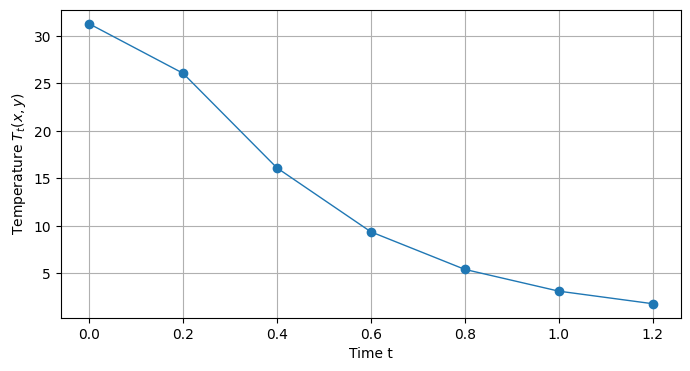

P0[1.5 1.5]: [31.285312240812843, 26.070480930487005, 16.109206260949904, 9.378938359503898, 5.424781739750457, 3.135404011762165, 1.8120465800957788]


In [63]:
point_index_to_observe = 0

P_points = [
    [Ut_anchor_points[t][point] for t in range(len(Trange))] for point in range(len(points_of_observations))
]

print(f"Temperature dynamics ({U0_type}) in P{point_index_to_observe+1}{points_of_observations[point_index_to_observe]} point:")
print(f"x*y = {Nx}*{Ny} points grid, \nN*M = {N}*{M} Fourier members,")
print(f"Cnm integrad error: {integrad_error}")

plt.figure(figsize=(8,4))
plt.plot(Trange, P_points[point_index_to_observe], "o-", linewidth=1)

plt.ylabel(r"Temperature $T_t(x,y)$")
plt.xlabel("Time t")

plt.grid()
plt.xticks(np.arange(0, Trange[-1]+0.01, step=Trange[-1]-Trange[-2]))

plt.savefig(f"Images/Fourier: {U0_type} point temperature dynamics.png", dpi=500, bbox_inches="tight")
plt.show()

print(f"P{point_index_to_observe}{points_of_observations[point_index_to_observe]}: {P_points[point_index_to_observe]}")

In [64]:
print(f"Temperature dynamics ({U0_type}): \nx*y = {Nx}*{Ny} points grid, \nN*M = {N}*{M} Fourier members,")
print(f"Cnm integrad error: {integrad_error}")

Fourier_temperature_dataframe = pd.DataFrame({
    "U0 exact": [
        U0(points_of_observations[point][0],points_of_observations[point][1],*U0_args) 
        for point in range(len(points_of_observations))
    ],
})

for t in range(len(Trange)):
    Fourier_temperature_dataframe[f"{Trange[t]}"] = [
        P_points[point][t] for point in range(len(points_of_observations))
    ]

Fourier_temperature_dataframe.index = [
    f"P{point+1}{list(points_of_observations[point])}" for point in range(len(points_of_observations))
]

Fourier_temperature_dataframe

Temperature dynamics (plato): 
x*y = 20*20 points grid, 
N*M = 30*30 Fourier members,
Cnm integrad error: 0


,U0 exact,0.0,0.2,0.4,0.6,0.8,1.0,1.2
"P1[1.5, 1.5]",30.0,31.285312,26.070481,16.109206,9.378938,5.424782,3.135404,1.812047
"P2[2.1, 1.5]",30.0,31.437692,22.203257,13.107632,7.592575,4.389054,2.536615,1.465978
"P3[2.5, 1.5]",30.0,31.926472,14.545100,8.155255,4.695982,2.712811,1.567729,0.906025
"P4[2.1, 2.1]",30.0,31.590813,18.909687,10.665330,6.146452,3.551072,2.052181,1.186002
"P5[2.5, 2.5]",30.0,32.580772,8.114923,4.128582,2.351252,1.356616,0.783878,0.453013


In [65]:
# Save the dataframe to a file
dataframe_filename = f"Dataframes/Fourier --{U0_type}-- temperature dataframe N*M:{N}*{M}.joblib"
joblib.dump(Fourier_temperature_dataframe, dataframe_filename)

print(f"\nDataframe saved as '{dataframe_filename}'")


Dataframe saved as 'Dataframes/Fourier --plato-- temperature dataframe N*M:30*30.joblib'


### 5. Temperature dynamics for different N*M grid

In [66]:
Fourier_temperature_10_10_dataframe = joblib.load(
    "Dataframes/Fourier --Gauss-- temperature dataframe N*M:10*10.joblib")
Fourier_temperature_20_20_dataframe = joblib.load(
    "Dataframes/Fourier --Gauss-- temperature dataframe N*M:20*20.joblib")
Fourier_temperature_30_30_dataframe = joblib.load(
    "Dataframes/Fourier --Gauss-- temperature dataframe N*M:30*30.joblib")

In [67]:
print(f"Gauss temperature dymanics, N*M:10*10")
Fourier_temperature_10_10_dataframe

Gauss temperature dymanics, N*M:10*10


,U0 exact,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0
"P1[2.5, 2.5]",1.000000,0.997612,0.666694,0.501525,0.407017,0.349554,0.313427,0.290220,0.275091,0.265126
"P2[3.5, 2.5]",0.606531,0.604529,0.478584,0.396065,0.343811,0.310239,0.288372,0.273981,0.264439,0.258080
"P3[4.5, 2.5]",0.135335,0.132935,0.198708,0.229727,0.242338,0.246779,0.247862,0.247710,0.247204,0.246679
"P4[3.5, 3.5]",0.367879,0.366330,0.343549,0.312781,0.290420,0.275346,0.265320,0.258650,0.254199,0.251221
"P5[4.5, 4.5]",0.018316,0.017714,0.059225,0.105228,0.144288,0.174222,0.196013,0.211427,0.222144,0.229515


In [68]:
print(f"Gauss temperature dymanics, N*M:20*20")
Fourier_temperature_20_20_dataframe

Gauss temperature dymanics, N*M:20*20


,U0 exact,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0
"P1[2.5, 2.5]",1.000000,1.000598,0.666695,0.501525,0.407017,0.349554,0.313427,0.290220,0.275091,0.265126
"P2[3.5, 2.5]",0.606531,0.607024,0.478584,0.396065,0.343811,0.310239,0.288372,0.273981,0.264439,0.258080
"P3[4.5, 2.5]",0.135335,0.135877,0.198708,0.229727,0.242338,0.246779,0.247862,0.247710,0.247204,0.246679
"P4[3.5, 3.5]",0.367879,0.368258,0.343550,0.312781,0.290420,0.275346,0.265320,0.258650,0.254199,0.251221
"P5[4.5, 4.5]",0.018316,0.018452,0.059225,0.105228,0.144288,0.174222,0.196013,0.211427,0.222144,0.229515


In [69]:
print(f"Gauss temperature dymanics, N*M:30*30")
Fourier_temperature_30_30_dataframe

Gauss temperature dymanics, N*M:30*30


,U0 exact,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0
"P1[2.5, 2.5]",1.000000,0.999739,0.666695,0.501525,0.407017,0.349554,0.313427,0.290220,0.275091,0.265126
"P2[3.5, 2.5]",0.606531,0.606317,0.478584,0.396065,0.343811,0.310239,0.288372,0.273981,0.264439,0.258080
"P3[4.5, 2.5]",0.135335,0.135119,0.198708,0.229727,0.242338,0.246779,0.247862,0.247710,0.247204,0.246679
"P4[3.5, 3.5]",0.367879,0.367716,0.343550,0.312781,0.290420,0.275346,0.265320,0.258650,0.254199,0.251221
"P5[4.5, 4.5]",0.018316,0.018262,0.059225,0.105228,0.144288,0.174222,0.196013,0.211427,0.222144,0.229515
